### Direct links to results
[Predicted profile examples](#prof-ex)

[Predicted profile heatmaps](#prof-heat)

In [1]:
import h5py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import tqdm
tqdm.tqdm_notebook(range(1))

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|<bar/>| 0/1 [00:00<?, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
# Define parameters/fetch arguments
preds_perf_path = os.environ["TFM_PRED_PATH"]

print("Predictions/performance path: %s" % preds_perf_path)

In [4]:
profile_length = 1000

### Helper functions
For plotting profiles and organizing predictions

In [6]:
def rank_predictions_by_norm_nll(preds_perf_path):
    """
    Computes the normalized NLL of all profiles in the saved predictions
    (averaging over tasks). Returns an N-array of normalized NLL values
    for each of the N predictions in the file.
    """
    reader = h5py.File(preds_perf_path, "r")
    nlls = reader["performance"]["nll"][:]  # Shape: N x T
    counts = reader["predictions"]["true_counts"][:]  # Shape: N x T x 2
    counts = np.sum(counts, axis=2)  # Shape: N x T
    num_seqs = counts.shape[0]
    
    # Normalize NLLs by counts, NaNs are okay (i.e. where count is 0)
    norm_nlls = nlls / counts
    
    # Average normalized NLLs over tasks
    norm_nlls_avg = np.nanmean(norm_nlls, axis=1)  # Shape: N
    
    return norm_nlls_avg

In [7]:
def rank_predictions_by_total_count(preds_perf_path):
    """
    Computes true total read count of all profiles in the saved predictions.
    Returns an N x T array of read count values for each of the N peaks
    in the file. Strands are summed.
    """
    reader = h5py.File(preds_perf_path, "r")
    counts = reader["predictions"]["true_counts"][:]  # Shape: N x T x 2
    counts = np.sum(counts, axis=2)  # Shape: N x T
    return counts

In [8]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles as a signal track.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task. No normalization is
    performed prior to plotting.
    """
    assert len(pred_profs.shape) == 3
    assert pred_profs.shape == true_profs.shape
    num_tasks, prof_length, _ = pred_profs.shape
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 2))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)
    plt.show()

In [9]:
def plot_profiles_from_file(preds_perf_path, example_index):
    """
    Plots the profiles using `plot_profiles` for the example at
    `example_index`.
    """
    reader = h5py.File(preds_perf_path, "r")
    coord = reader["coords"]
    chrom = coord["coords_chrom"][example_index].decode()
    start = coord["coords_start"][example_index]
    end = coord["coords_end"][example_index]
    
    log_pred_profs = reader["predictions"]["log_pred_profs"][example_index]
    true_profs = reader["predictions"]["true_profs"][example_index]
    
    pred_profs = np.exp(log_pred_profs) * np.sum(true_profs, axis=1, keepdims=True)
    plot_profiles(pred_profs, true_profs, title=("%s:%d-%d" % (chrom, start, end)))

In [10]:
def plot_best_unique_coordinates(preds_perf_path, norm_nlls, num_to_plot=5):
    """
    Plots the top `num_to_plot` intervals, taking only unique ones
    that don't overlap at all. `norm_nlls` is an N-array of average normalized
    NLL values for each peak.
    """
    reader = h5py.File(preds_perf_path, "r")
    sorted_inds = np.argsort(norm_nlls)
    seen = np.empty((0, 3), dtype=object)
    next_index = 0
    num_found = 0
    while num_found < num_to_plot and next_index < len(sorted_inds):
        example_index = sorted_inds[next_index]
        coord = reader["coords"]
        chrom = coord["coords_chrom"][example_index].decode()
        start = coord["coords_start"][example_index]
        end = coord["coords_end"][example_index]
        mask = (seen[:, 0] == chrom) & (seen[:, 1] < end) & (seen[:, 2] > start)
        if not np.any(mask):
            plot_profiles_from_file(preds_perf_path, example_index)
            seen = np.concatenate([seen, np.array([[chrom, start, end]], dtype=object)])
            num_found += 1
        next_index += 1

In [11]:
def plot_profiles_heatmap(pred_profs, true_profs, normalize=True, title=None):
    """
    Plots the given profiles as a heatmap.
    Both arguments should be N x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task. No normalization is
    performed prior to plotting. Assumes that the profiles are all summit-centered.
    """
    assert len(pred_profs.shape) == 3
    assert pred_profs.shape == true_profs.shape
    num_profs, _, _ = pred_profs.shape

    def normalize(arr, axis=1):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return arr / arr_sum
    # If specified, normalize the profiles along the profile dimension
    true_profs_norm = normalize(true_profs, axis=1)
    pred_profs_norm = normalize(pred_profs, axis=1)

    # Compute the mean profiles across all examples
    true_profs_mean = np.mean(true_profs_norm, axis=0)
    pred_profs_mean = np.mean(pred_profs_norm, axis=0)

    # Compute a matrix of profiles, normalized to the maximum value in each profile
    def make_profile_matrix(flat_profs):
        matrix = flat_profs
        maxes = np.max(matrix, axis=1, keepdims=True)
        maxes[maxes == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return matrix / maxes
    true_matrix = make_profile_matrix(true_profs_norm)
    pred_matrix = make_profile_matrix(pred_profs_norm)

    # Create a figure with the right dimensions
    mean_height = 4
    heatmap_height = min(num_profs * 0.05, 8)
    fig_height = mean_height + (2 * heatmap_height)
    fig, ax = plt.subplots(
        3, 2, figsize=(16, fig_height), sharex=True,
        gridspec_kw={
            "width_ratios": [1, 1],
            "height_ratios": [mean_height / fig_height, heatmap_height / fig_height, heatmap_height / fig_height]
        }
    )

    # Plot the average predictions
    ax[0, 0].plot(true_profs_mean[:, 0], color="darkslateblue")
    ax[0, 0].plot(-true_profs_mean[:, 1], color="darkorange")
    ax[0, 1].plot(pred_profs_mean[:, 0], color="darkslateblue")
    ax[0, 1].plot(-pred_profs_mean[:, 1], color="darkorange")

    # Set axes on average predictions
    max_mean_val = max(np.max(true_profs_mean), np.max(pred_profs_mean))
    mean_ylim = max_mean_val * 1.05  # Make 5% higher
    ax[0, 0].set_title("True profiles")
    ax[0, 0].set_ylabel("Average probability")
    ax[0, 1].set_title("Predicted profiles")
    for j in (0, 1):
        ax[0, j].set_ylim(-mean_ylim, mean_ylim)
        ax[0, j].label_outer()

    print(true_matrix.shape)
    print(pred_matrix.shape)
    
    # Plot the heatmaps
    ax[1, 0].imshow(true_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
    ax[1, 1].imshow(pred_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
    ax[2, 0].imshow(true_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")
    ax[2, 1].imshow(pred_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")

    # Set axes on heatmaps
    for i in (1, 2):
        for j in (0, 1):
            ax[i, j].set_yticks([])
            ax[i, j].set_yticklabels([])
            ax[i, j].label_outer()
    width = true_matrix.shape[1]
    delta = 100
    num_deltas = (width // 2) // delta
    labels = list(range(max(-width // 2, -num_deltas * delta), min(width // 2, num_deltas * delta) + 1, delta))
    tick_locs = [label + max(width // 2, num_deltas * delta) for label in labels]
    for j in (0, 1):
        ax[2, j].set_xticks(tick_locs)
        ax[2, j].set_xticklabels(labels)
        ax[2, j].set_xlabel("Distance from peak summit (bp)")

    if title:
        fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [12]:
def plot_highest_signal_heatmaps(preds_perf_path, total_counts, num_to_plot=1000):
    """
    For each task, plots the top `num_to_plot` intervals based on total counts.
    `total_counts` is an N x T array of total counts for each coordinate.
    """
    reader = h5py.File(preds_perf_path, "r")
    num_coords, num_tasks = total_counts.shape
    num_to_plot = min(num_to_plot, num_coords)
    
    for task_index in range(num_tasks):
        example_inds = np.flip(np.argsort(total_counts[:, task_index]))[:num_to_plot]
        sorted_inds = np.sort(example_inds)
        index_map = np.unique(example_inds, return_inverse=True)[1]
        
        log_pred_profs = reader["predictions"]["log_pred_profs"][sorted_inds][:, task_index]
        true_profs = reader["predictions"]["true_profs"][sorted_inds][:, task_index]
        pred_profs = np.exp(log_pred_profs) * np.sum(true_profs, axis=1, keepdims=True)
        
        true_profs = true_profs[index_map]
        pred_profs = pred_profs[index_map]
            
        plot_profiles_heatmap(pred_profs, true_profs, title=("Task %d" % task_index))

<a id="prof-ex"></a>
### Selected profile examples
Best-predicted profiles (non-overlapping)

In [13]:
norm_nlls = rank_predictions_by_norm_nll(preds_perf_path)

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


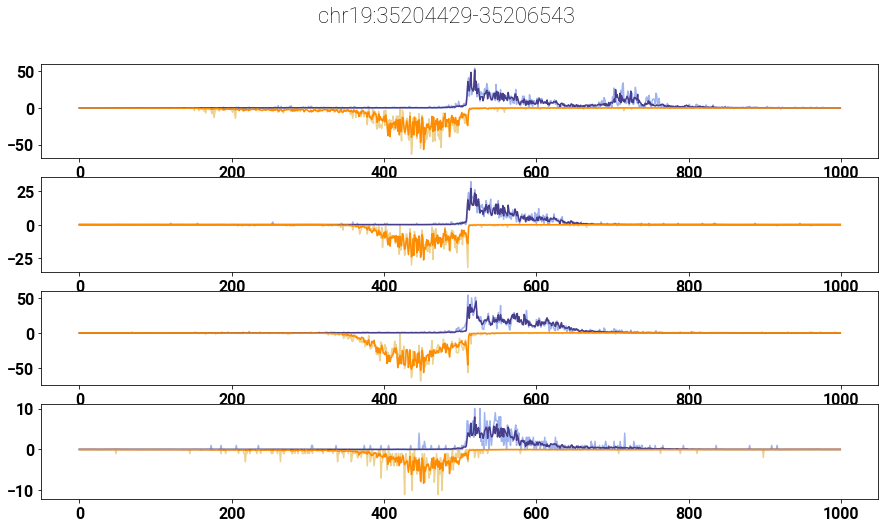

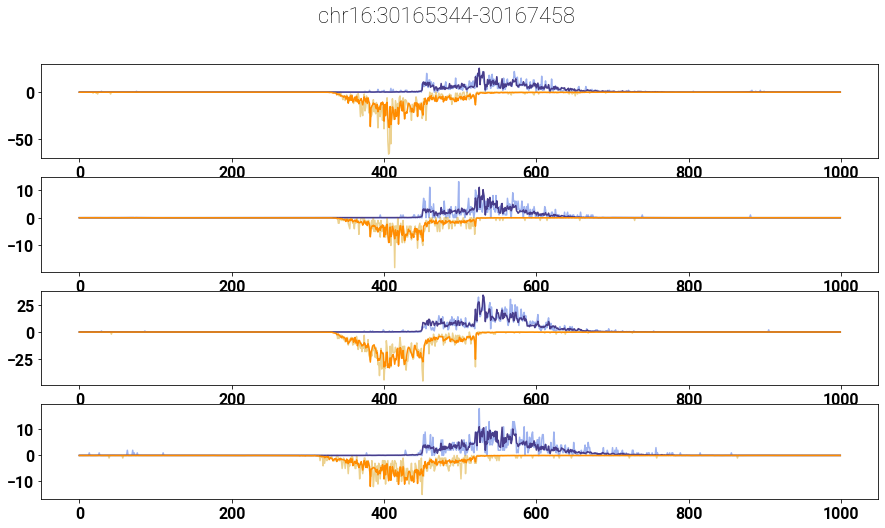

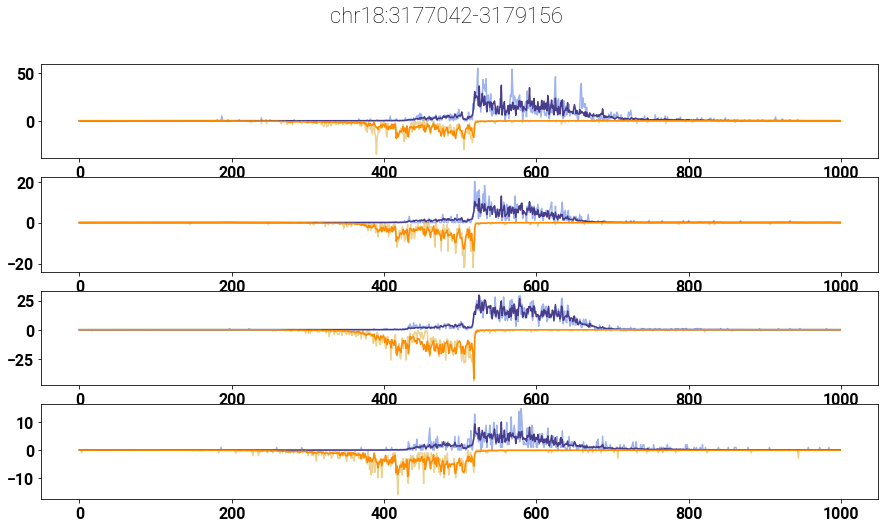

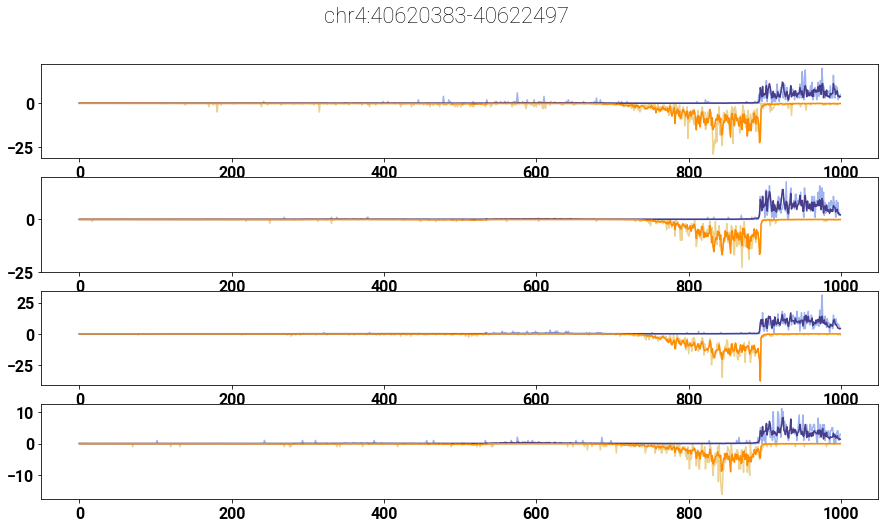

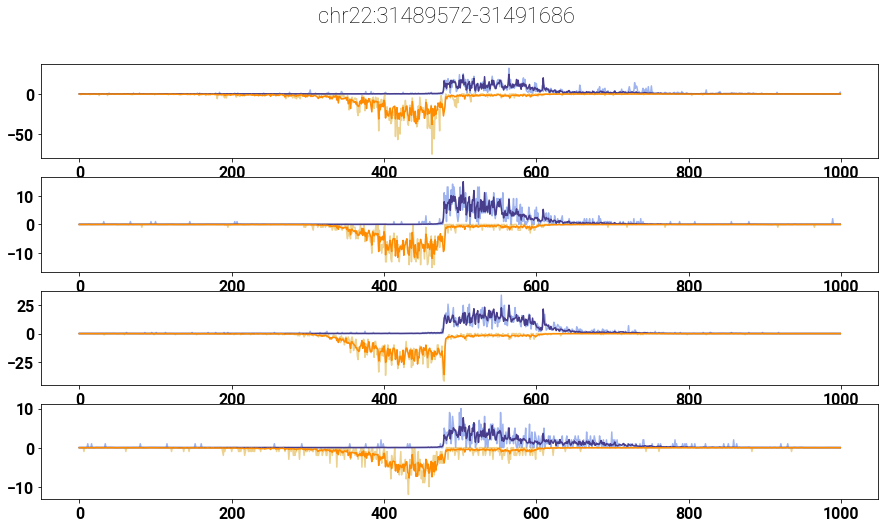

In [14]:
plot_best_unique_coordinates(preds_perf_path, norm_nlls, num_to_plot=5)

<a id="prof-heat"></a>
### Heatmap of profiles

In [15]:
total_counts = rank_predictions_by_total_count(preds_perf_path)

(1000, 1000, 2)
(1000, 1000, 2)


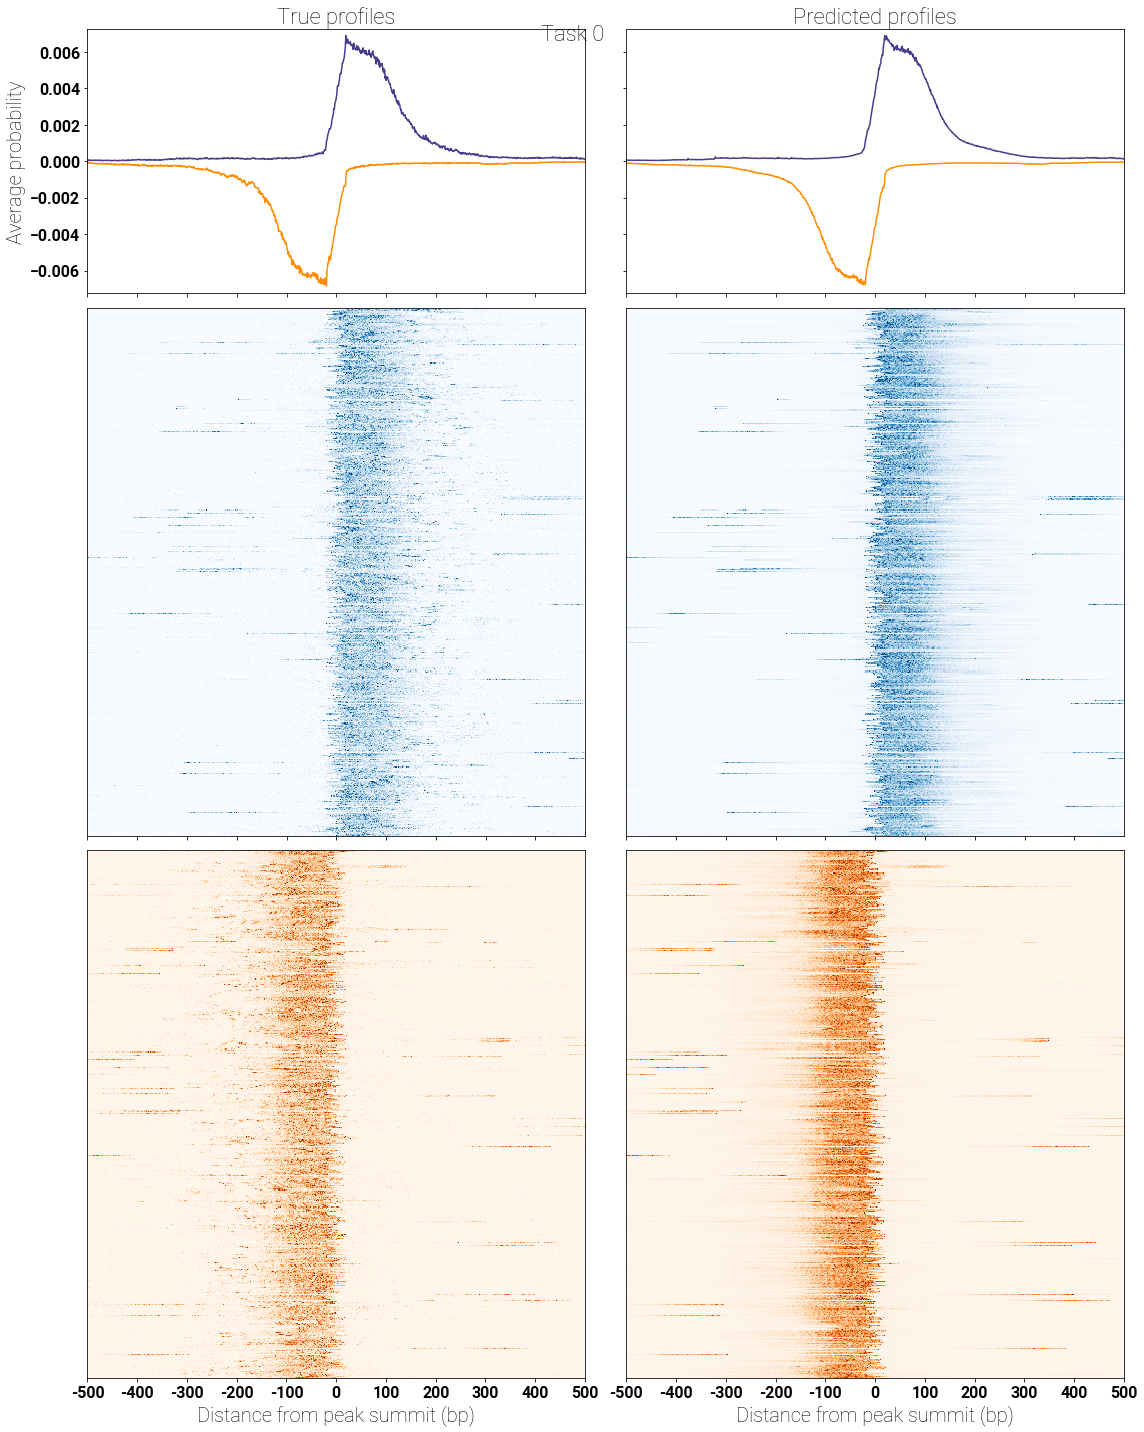

(1000, 1000, 2)
(1000, 1000, 2)


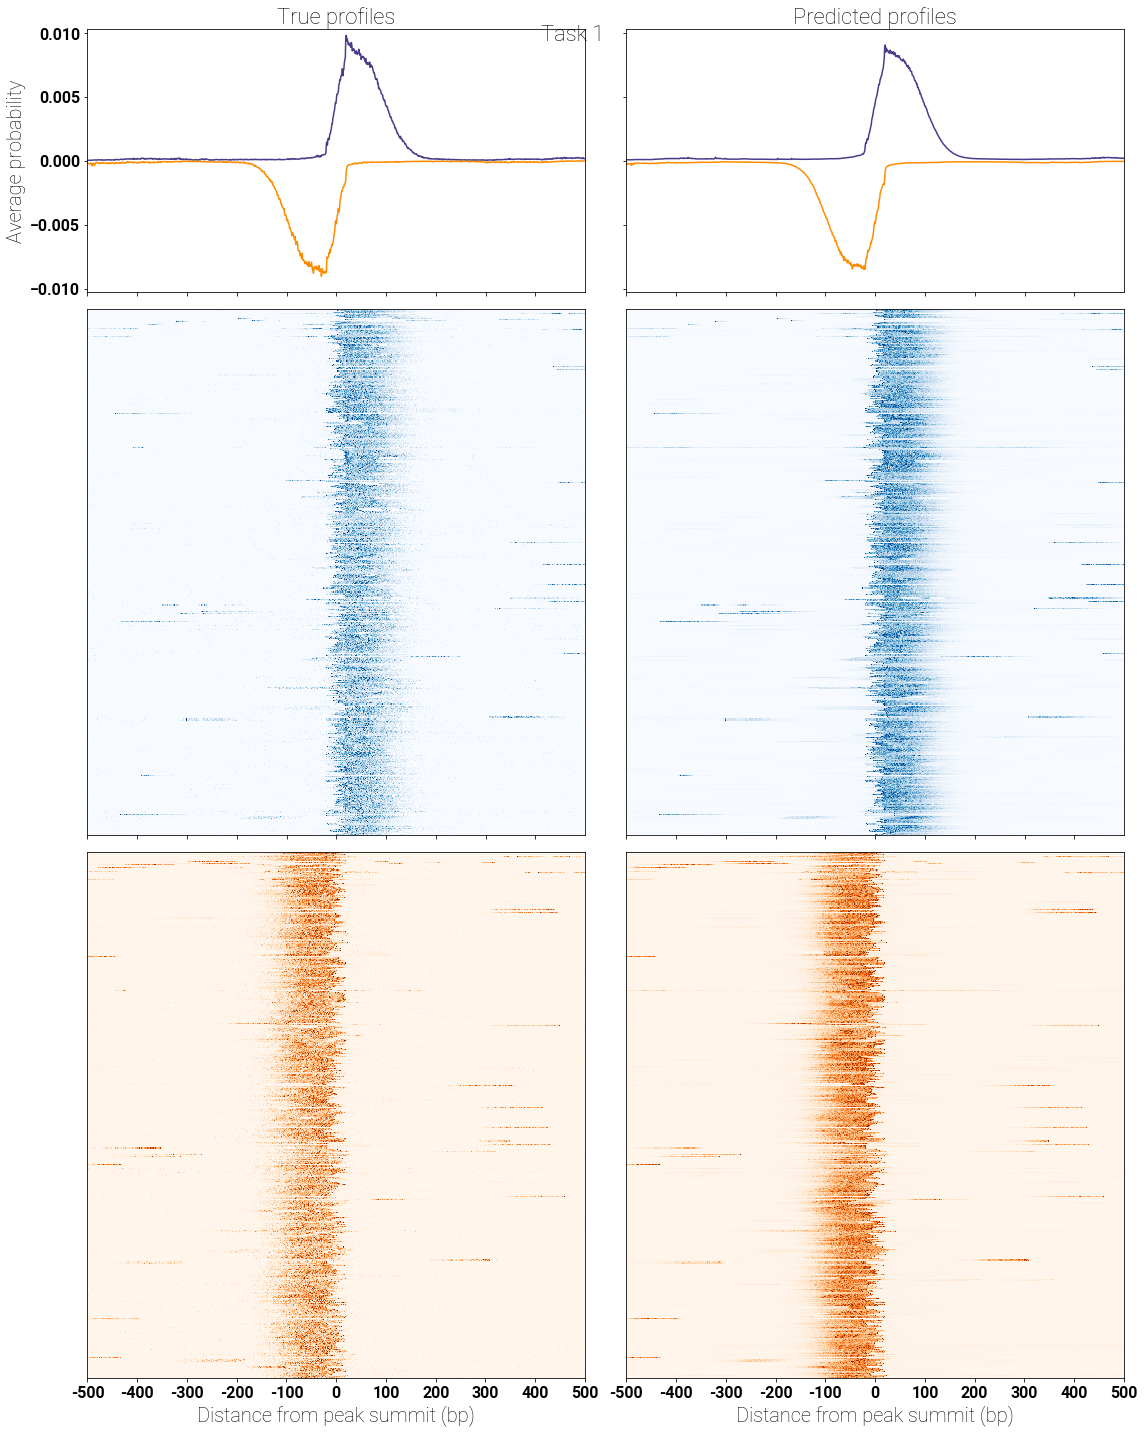

(1000, 1000, 2)
(1000, 1000, 2)


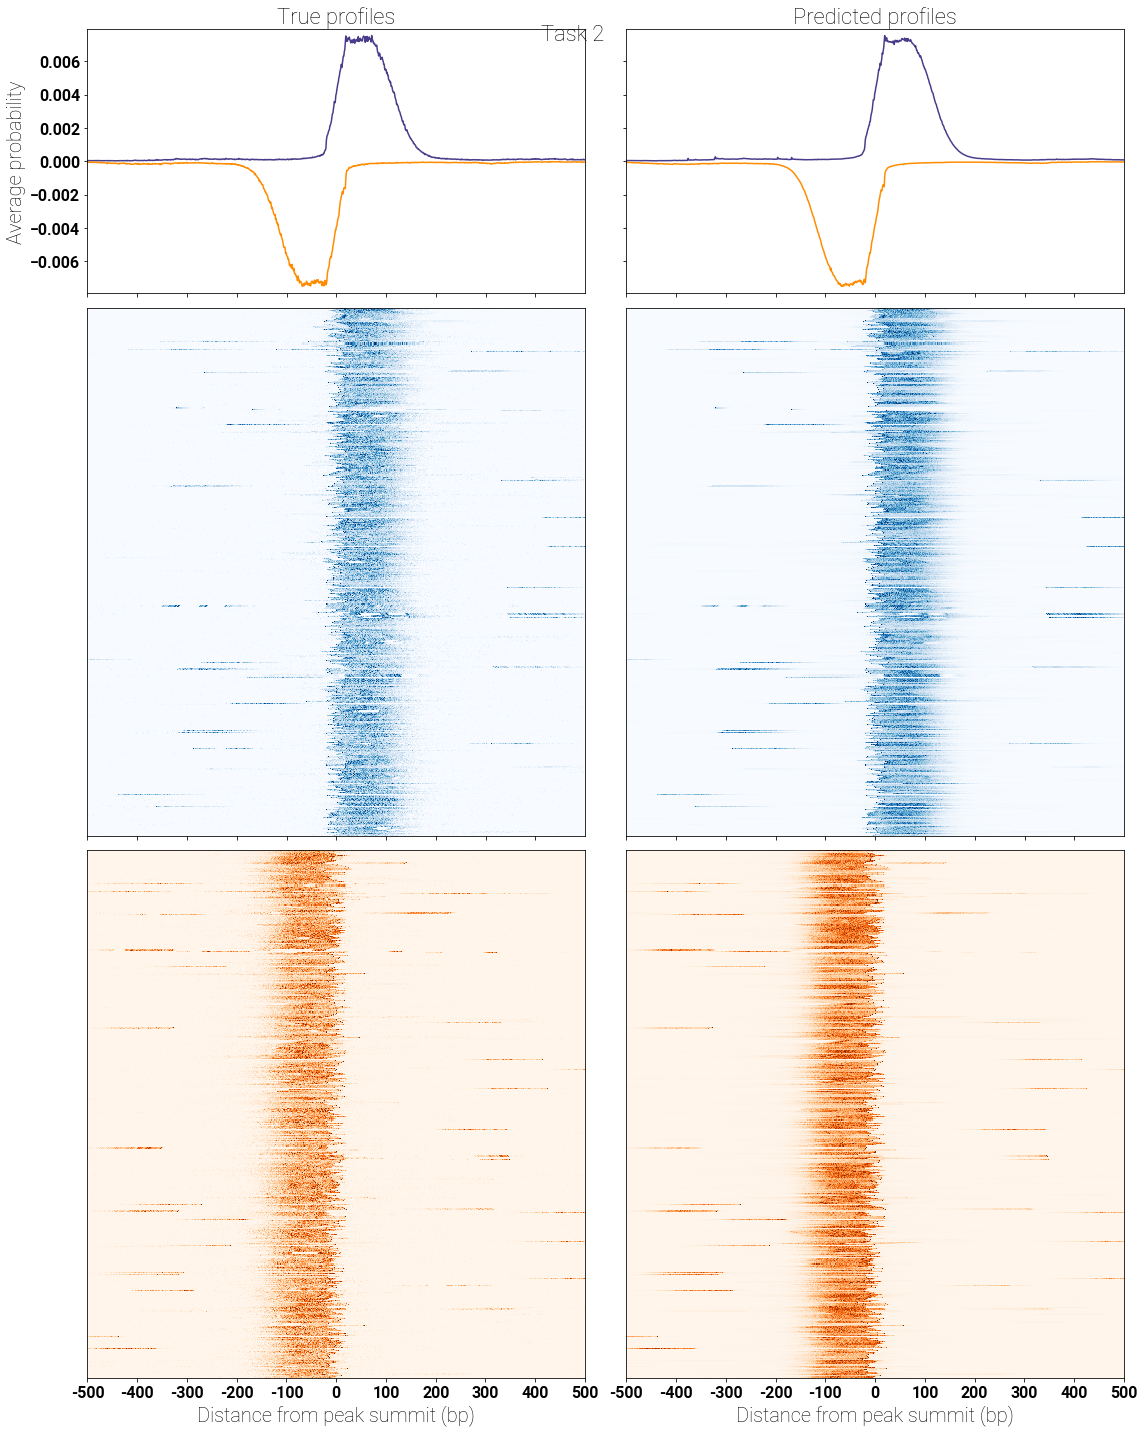

(1000, 1000, 2)
(1000, 1000, 2)


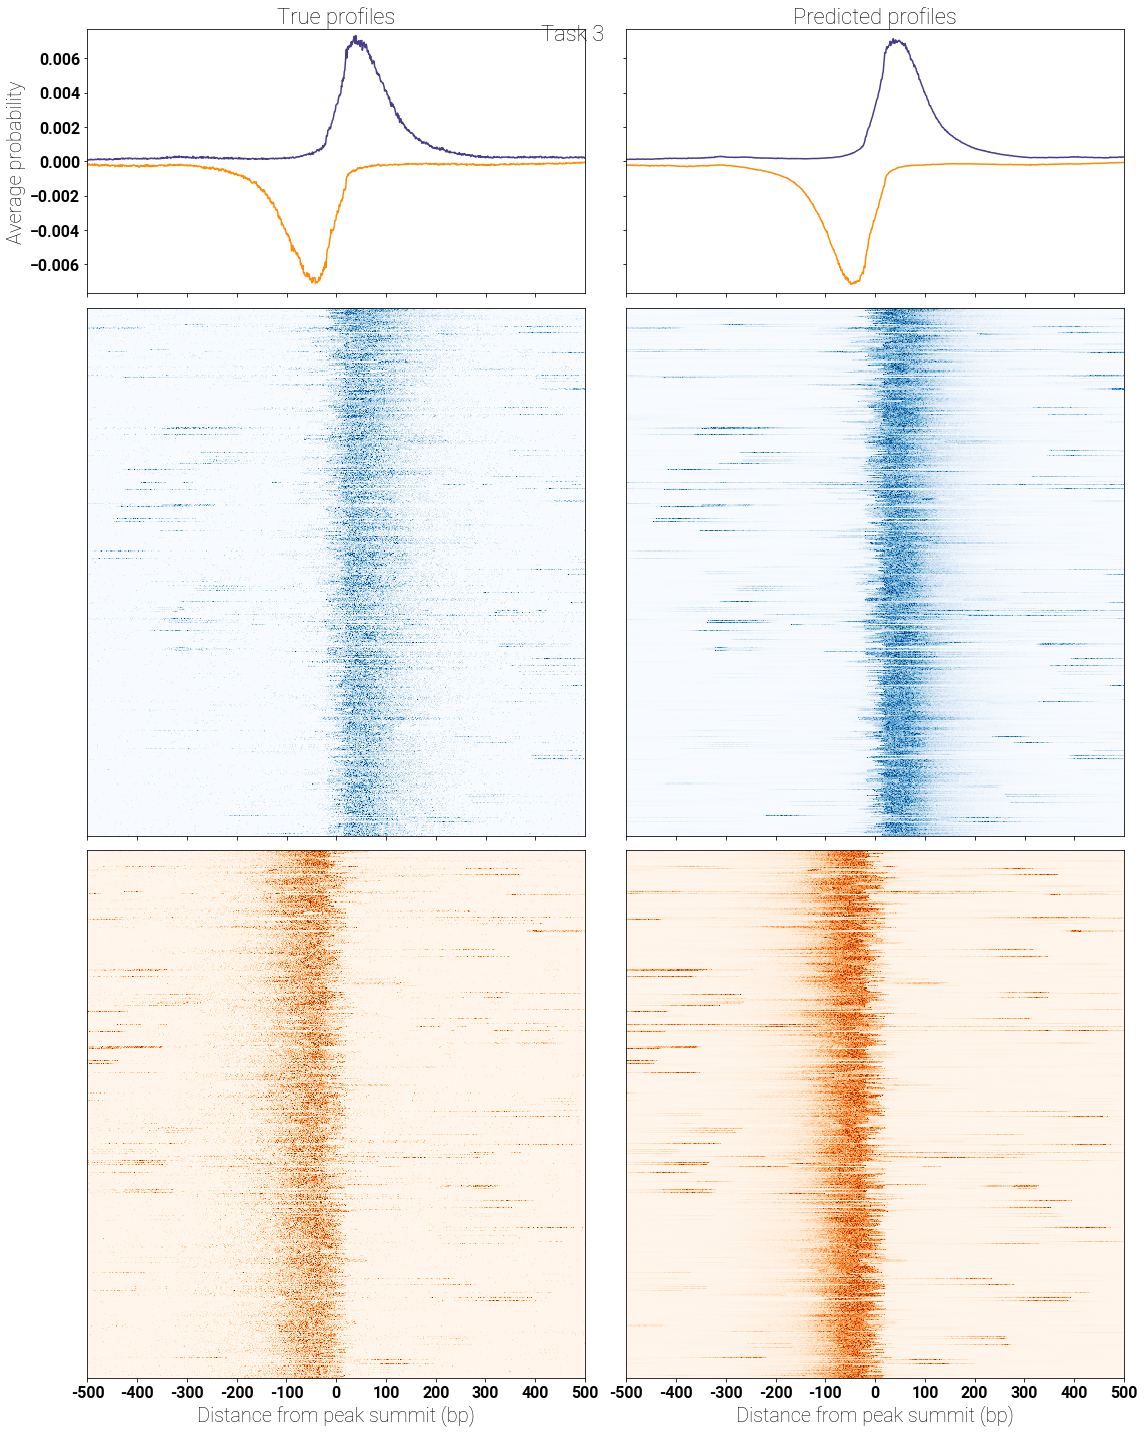

In [16]:
plot_highest_signal_heatmaps(preds_perf_path, total_counts, num_to_plot=1000)